# 딥러닝 RNN 기반의 검색 빈도수를 이용한 주가예측
 - FCN 모델은 현재 시점만 보고 결정: 야 너 지금 가격 35500원인데 살래말래?
 - 반면 RNN은 어제, 그제, 그그제 가격이 42300, 41000, 37000원 이었거든? 살래말래?

# 0. Install packages

In [1]:
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 1.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [3]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,78400,1,2900,3.84,77500,78500,77200,12595284,981400452400,468030951920000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,179600,1,8600,5.03,178900,180000,176300,2713427,484994958200,130749224754000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,381500,1,11500,3.11,380500,389500,378000,155505,59514138000,89271000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,792000,1,1000,0.13,799000,804000,790000,19801,15736189000,56369808000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,65300,1,1800,2.83,64200,65300,64200,865625,56014156400,53734501510000,822886700,STK


In [4]:
df = fdr.DataReader('036570','2020-01-01', '2022-04-12') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [5]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,542000,545000,539000,541000,40246,0.000000
2020-01-03,547000,568000,542000,565000,112404,0.044362
2020-01-06,562000,587000,562000,579000,107006,0.024779
2020-01-07,583000,596000,574000,594000,84378,0.025907
2020-01-08,587000,604000,584000,604000,109267,0.016835
...,...,...,...,...,...,...
2022-04-06,475000,483500,469000,474000,96750,-0.012500
2022-04-07,469000,471500,462000,462000,103079,-0.025316
2022-04-08,462500,466500,453500,458000,87055,-0.008658


In [6]:
df = df.fillna(0)

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993., 19083.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01'),
  Text(19083.0, 0, '2022-04')])

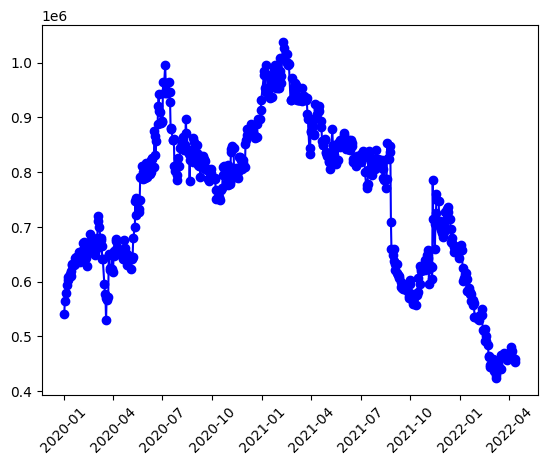

In [7]:
plt.plot(df['Close'], 'bo-')
plt.xticks(rotation=45)

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [8]:
import os
import sys
import urllib.request
client_id = "8sAydq_QSOxKcICuD2Og"
client_secret = "OruQjbmaXF"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2020-01-01\",\"endDate\":\"2022-04-12\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"NCSoft_N\",\"keywords\":[\"NCSoft\",\"환불\",\"사건\"]}, {\"groupName\":\"NCSoft_P\",\"keywords\":[\"리니지\",\"업데이트\"]}]}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [9]:
search_count_json = json.loads(search_count)

In [10]:
search_count_json["results"][1]

{'title': 'NCSoft_P',
 'keywords': ['리니지', '업데이트'],
 'data': [{'period': '2020-01-01', 'ratio': 28.41534},
  {'period': '2020-01-02', 'ratio': 41.62007},
  {'period': '2020-01-03', 'ratio': 30.74559},
  {'period': '2020-01-04', 'ratio': 28.62447},
  {'period': '2020-01-05', 'ratio': 24.94131},
  {'period': '2020-01-06', 'ratio': 30.28893},
  {'period': '2020-01-07', 'ratio': 32.89232},
  {'period': '2020-01-08', 'ratio': 51.4532},
  {'period': '2020-01-09', 'ratio': 33.05876},
  {'period': '2020-01-10', 'ratio': 28.79945},
  {'period': '2020-01-11', 'ratio': 24.73219},
  {'period': '2020-01-12', 'ratio': 25.06935},
  {'period': '2020-01-13', 'ratio': 27.75809},
  {'period': '2020-01-14', 'ratio': 28.29584},
  {'period': '2020-01-15', 'ratio': 32.61917},
  {'period': '2020-01-16', 'ratio': 29.39695},
  {'period': '2020-01-17', 'ratio': 27.58738},
  {'period': '2020-01-18', 'ratio': 23.97251},
  {'period': '2020-01-19', 'ratio': 22.12026},
  {'period': '2020-01-20', 'ratio': 25.24433},
 

## 1-3. 데이터 전처리 및 Merge하기

In [11]:
for idx in range(len(search_count_json["results"])):

  df_json = pd.DataFrame(search_count_json["results"][idx]["data"])
  column_name = 'Key_Count'+str(idx)
  df_json.columns = ['Date', column_name]
  df_json['Date'] = pd.to_datetime(df_json['Date'])
  df_json.reset_index(drop=True)
  df_json.set_index("Date")
  #Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html
  df = pd.merge_asof(df, df_json, on="Date", by="Date")

In [12]:
df_all = df

In [13]:
df_all["Change"].sum() # 전체 주가의 변동폭은 2020년부터 현재까지 증가일까 감소일까? 최종 주가는 빠졌는데 놀랍게도 증가함.. 이는 복리의 함정

0.07053067344563524

In [14]:
df_all[df_all["Date"] > '2022-01-01']["Change"].sum() #조금 더 범위를 좁혀 그러면 2022년 전체 주가 변동폭만 검색해보자, 역시 폭락중 불쌍한 임교수

-0.3216858919029978

In [15]:
#df_all[df_all["Count"].notnull()]["Change"].sum() # 그렇다면 해당 키워드가 검색된 날만 뽑아 주가가 상승했는지 하락인지 살펴보자.

In [16]:
# Fill nan as 0
df_all = df_all.fillna(0)
df_all.any().isnull()

<ipython-input-16-8321ed6eb302>:3: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  df_all.any().isnull()


Date          False
Open          False
High          False
Low           False
Close         False
Volume        False
Change        False
Key_Count0    False
Key_Count1    False
dtype: bool

In [17]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Key_Count0,Key_Count1
0,2020-01-02,542000,545000,539000,541000,40246,0.000000,3.18808,41.62007
1,2020-01-03,547000,568000,542000,565000,112404,0.044362,3.20088,30.74559
2,2020-01-06,562000,587000,562000,579000,107006,0.024779,3.59352,30.28893
3,2020-01-07,583000,596000,574000,594000,84378,0.025907,3.55511,32.89232
4,2020-01-08,587000,604000,584000,604000,109267,0.016835,3.90508,51.45320
...,...,...,...,...,...,...,...,...,...
558,2022-04-06,475000,483500,469000,474000,96750,-0.012500,3.46976,16.67875
559,2022-04-07,469000,471500,462000,462000,103079,-0.025316,3.69595,13.18765
560,2022-04-08,462500,466500,453500,458000,87055,-0.008658,3.39720,12.20178
561,2022-04-11,450500,459000,449000,453500,59322,-0.009825,3.57645,11.35674


## 1-4. Feature Selection

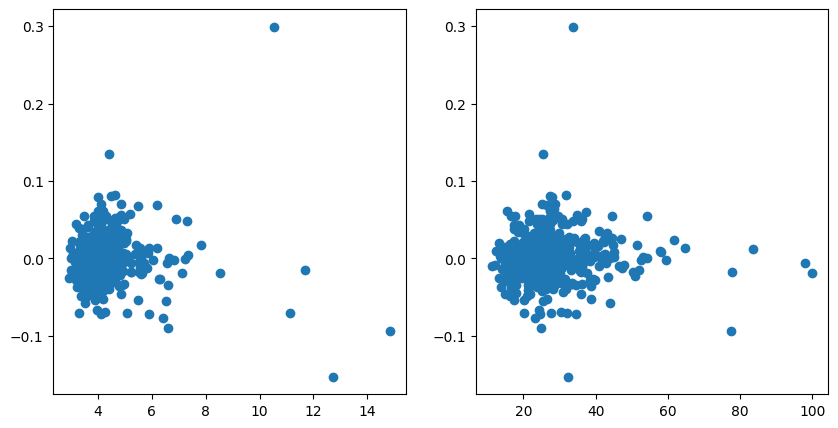

In [18]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(df_all["Key_Count0"], df_all["Change"])
ax2.scatter(df_all["Key_Count1"], df_all["Change"])


# 2. Define Model

In [19]:
#https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
#rnn 예제를 보고 일단 한번 돌려봅시다
rnn = torch.nn.RNN(2, 100, 1, batch_first=True)
input = torch.randn(1, 5, 2)
h0 = torch.randn(1, 1, 100)
output, hn = rnn(input, h0)

In [20]:
'''
input_size = 2
batch_size = 1
sequence_size = 5
hidden_size = 100
layer_size = 1
batch_first = True
rnn = torch.nn.RNN(input_size, hidden_size, layer_size, batch_first=batch_first)
input = torch.randn(batch_size, sequence_size, input_size)
h0 = torch.randn(1*layer_size, batch_size, hidden_size)
output, hn = rnn(input, h0) #(모든 sequence에 대한 hidden 값, 맨마지막 seq에 대한 hidden 값)
'''

'\ninput_size = 2\nbatch_size = 1\nsequence_size = 5\nhidden_size = 100\nlayer_size = 1\nbatch_first = True\nrnn = torch.nn.RNN(input_size, hidden_size, layer_size, batch_first=batch_first)\ninput = torch.randn(batch_size, sequence_size, input_size)\nh0 = torch.randn(1*layer_size, batch_size, hidden_size)\noutput, hn = rnn(input, h0) #(모든 sequence에 대한 hidden 값, 맨마지막 seq에 대한 hidden 값)\n'

In [21]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layer=1, batch_first=True):
        super(RNNModel, self).__init__()
        self.rnn = torch.nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layer, batch_first=batch_first)
        self.relu = torch.nn.ReLU()
        self.linear_classifier = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):

        all_hidden, last_hidden = self.rnn(x.unsqueeze(0))
        #x = self.relu(last_hidden)
        x = self.linear_classifier(all_hidden[:, -1])
        return x

# 3. Define the loss function and the optimizer

In [22]:
input_size = 2
hidden_size = 10
sequence_size = 5
output_size = 1
layer_size = 1

learning_rate = 0.001
model = RNNModel(input_size, hidden_size, output_size)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [23]:
def train(train_x, train_y, loss_function, optimizer, model):
  total_loss = []

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    logit = model(train_x_tensor)
    loss = loss_function(logit, train_y_tensor)
    total_loss.append(loss.item())

    loss.backward()
    optimizer.step()

  return total_loss

# 5. Training

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Scaled_Key_Count0','Scaled_Key_Count1']] = scaler.fit_transform(df[['Key_Count0','Key_Count1']])

In [25]:
df_all = df

In [26]:
'''
s_idx, e_idx, date_interval, num_days = 0, len(df_all), 1, 4
for idx in range(s_idx, e_idx-s_idx, date_interval):
  print(df_all.loc[idx:idx+num_days])
'''

'\ns_idx, e_idx, date_interval, num_days = 0, len(df_all), 1, 4\nfor idx in range(s_idx, e_idx-s_idx, date_interval):\n  print(df_all.loc[idx:idx+num_days])\n'

In [27]:
seq_x = []
seq_y = []
feature_list = ['Scaled_Key_Count0','Scaled_Key_Count1']
s_idx, e_idx, date_interval, num_days = 0, len(df_all), 1, 4
for idx in range(s_idx, e_idx-s_idx, date_interval):
  x = df_all.loc[idx:idx+num_days][feature_list].to_numpy().tolist()
  y = df_all.loc[idx:idx+num_days]["Change"].sum().tolist()
  seq_x.append(x) if len(x) == 5 else None
  seq_y.append(y) if len(x) == 5 else None

train_x, test_x, train_y, test_y = train_test_split(seq_x, seq_y, test_size=0.2)

In [28]:
from tqdm import tqdm

best_model = None
num_epoch = 500
loss_epoch = []

for epoch in tqdm(range(num_epoch)):
    loss_list = train(train_x, train_y, loss_function, optimizer, model)
    loss_epoch.append(sum(loss_list)/len(train_x))

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 500/500 [07:27<00:00,  1.12it/s]


<BarContainer object of 500 artists>

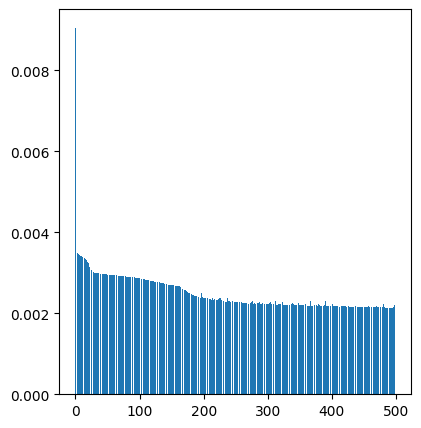

In [29]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)

ax1.bar(range(num_epoch), loss_epoch)

# 7. Evaluation

In [37]:
x_predicted = []
for idx in range(len(test_x)):
  predicted = model(torch.tensor(test_x[idx]).float())
  x_predicted.append(predicted.detach())
x_pred_np = np.array(x_predicted)

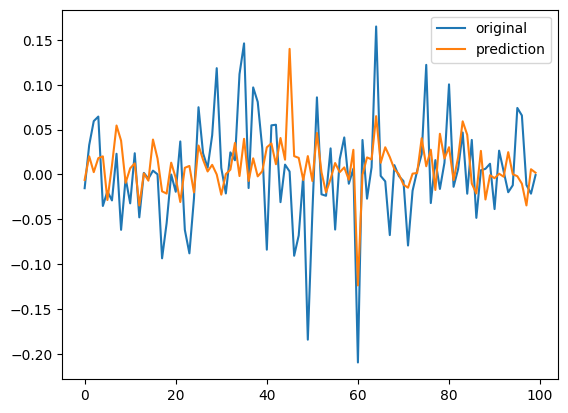

In [41]:
x_pred_np_squeezed = x_pred_np.squeeze()

plt.plot(test_y[:100])
plt.plot(x_pred_np_squeezed[:100])
plt.legend(['original', 'prediction'])
plt.show()

# 6. Prediction

In [32]:
def predict(key_count, model):
  model.eval()
  logit = model(key_count)
  return logit

In [33]:
raw_input = [[3,30],[2,25],[5.5,19],[3.2,29],[3.3,29]]
scaled_input = []
for a_day in raw_input:
  key_count = np.array(a_day)
  scaled = scaler.transform(key_count.reshape(1,-1)).tolist()[0]
  scaled_input.append(scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [34]:
scaled_input

[[0.004288664517281021, 0.21031785157720959],
 [-0.07993491202005193, 0.15391198383272456],
 [0.21484760586061333, 0.08622494253934254],
 [0.021133379824747583, 0.19903667802831262],
 [0.029555737478480865, 0.19903667802831262]]

In [35]:
df_all.max()
predicted = predict(torch.FloatTensor(scaled_input), model)

In [36]:
print("검색량이"+str(raw_input)+"일때 주가는", str(predicted.item()*100) )

검색량이[[3, 30], [2, 25], [5.5, 19], [3.2, 29], [3.3, 29]]일때 주가는 -2.2338619455695152
